In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import SmoothBivariateSpline
import statsmodels.api as sm

import sys
sys.path.append("../")

from electronfactors.model.threshold import angle_gap, fit_give
from electronfactors.model.utilities import *

In [2]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)

In [3]:
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

In [4]:
np.sum(book_factor)

7

In [5]:
# custom_label = label[~book_factor]
# custom_label = label[label != 'P3']

custom_label = label

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

In [6]:
len(width)

42

In [7]:
def to_eqPonA(width, length):
    perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
    area = np.pi / 4 * width * length
    
    eqPonA = perimeter / area
    
    return eqPonA

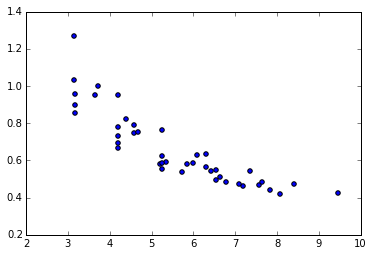

In [8]:
eqPonA = to_eqPonA(width, length)

plt.scatter(width, eqPonA)

In [9]:
ky = 1

def create_model(width, eqPonA, factor):
    
    def model(x, y):

        spline = SmoothBivariateSpline(
            width, eqPonA, factor, kx=2, ky=1)

        result = spline.ev(x, y)

        return result
    
    return model

In [10]:
model = create_model(width, eqPonA, factor)

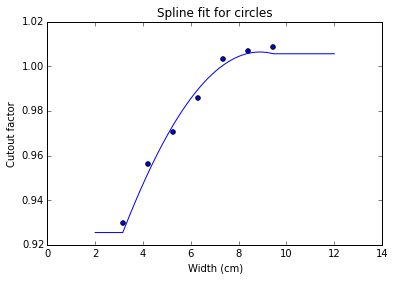

In [11]:
circle_test_width = np.linspace(2,12, 1000)
circle_test_eqPonA = to_eqPonA(circle_test_width, circle_test_width)

circle_test_prediction = model(circle_test_width, circle_test_eqPonA)
plt.plot(circle_test_width, circle_test_prediction)
circle_ref = np.abs(width - length) < 0.1
plt.scatter(width[circle_ref], factor[circle_ref])

plt.xlabel('Width (cm)')
plt.ylabel('Cutout factor')
plt.title('Spline fit for circles')

In [12]:
x = np.arange(np.floor(np.min(width)), np.ceil(np.max(width)), 0.1)
y = np.arange(np.floor(np.min(eqPonA)*10)/10, np.ceil(np.max(eqPonA)*10)/10, 0.01)

xx, yy = np.meshgrid(x, y)

zz = model(xx, yy)
give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=ky)
gap = angle_gap(xx, yy, width, eqPonA, 1, 1)

maximum_eqPonA = to_eqPonA(xx, xx)

outOfTolerance = (give > 0.5) | (gap > 180) | (yy > maximum_eqPonA)

zz[outOfTolerance] = np.nan
    
zz = np.floor(zz*1e4)/1e4

In [13]:
circle_width = np.linspace(np.min(width), np.max(width))
circle_eqPonA = to_eqPonA(circle_width, circle_width)

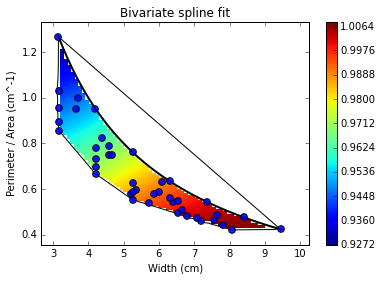

In [14]:
c = plt.contourf(xx,yy,zz,100, alpha=1)
plt.colorbar(c)

# plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='k', lw=2)

plt.plot(circle_width, circle_eqPonA, 'k', lw=2)

plt.scatter(width, eqPonA, s=45, alpha=0.9, zorder=3)

plt.xlabel('Width (cm)')
plt.ylabel('Perimeter / Area (cm^-1)')
plt.title('Bivariate spline fit')

In [15]:
x = np.arange(np.floor(np.min(width)) - 1, np.ceil(np.max(length)) + 1, 0.1)
y = x

xx, yy = np.meshgrid(x,y)
   
mesh_width = xx.copy()
mesh_width[xx>yy] = yy[xx>yy]

mesh_length = xx.copy()
mesh_length[yy>xx] = yy[yy>xx]

mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

zz = model(mesh_width, mesh_eqPonA)
give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=ky)
gap = angle_gap(mesh_width, mesh_eqPonA, width, eqPonA, 1, 1)

outOfTolerance = (give > 0.5) | (gap > 180)

zz[outOfTolerance] = np.nan
    
zz = np.floor(zz*1e4)/1e4

(0.0, 16.0, 0.0, 16.0)

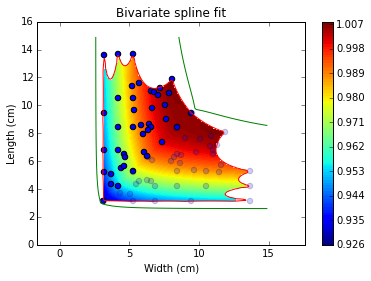

In [16]:
c = plt.contourf(xx,yy,zz,100)
plt.colorbar(c)

plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='r')

plt.scatter(width, length, s=30)
plt.scatter(length, width, s=30, alpha=0.2)

plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
plt.title('Bivariate spline fit')

plt.axis('equal')

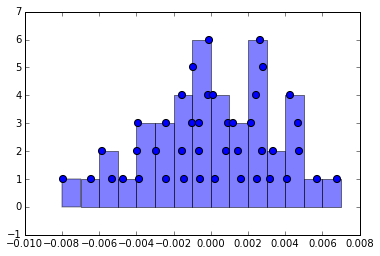

In [17]:
residuals_lengthwidth = factor - model(width, eqPonA)

binSize = np.floor(4 * residuals_lengthwidth.ptp() / len(residuals_lengthwidth) / 0.0005) * 0.0005
binStart = np.floor(residuals_lengthwidth.min()/binSize)*binSize
binEnd = np.ceil(residuals_lengthwidth.max()/binSize)*binSize

bins = np.arange(binStart,binEnd+binSize,binSize)

dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - residuals_lengthwidth),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):
    binRef = (binNum == i)
    representative_height[binRef] = np.arange(sum(binRef)) + 1

plt.hist(residuals_lengthwidth,bins,alpha=0.5)
plt.scatter(residuals_lengthwidth,representative_height,zorder=2,s=50,)

In [18]:
label[np.argsort(np.abs(residuals_lengthwidth))][::-1]

array(['Simon #58 cutout', 'Simon #22 cutout', 'Simon #82 cutout',
       'Simon 3x9cm oval', 'Simon #19 cutout', 'Simon #57 cutout',
       'Simon 3x6.5cm oval', 'Simon #6 cutout', 'Simon #83 cutout',
       'Simon #32 cutout', 'P3', 'Simon 9cm circle', 'Simon 7cm circle',
       'Simon #14 cutout', 'Simon 4cm circle', 'Simon #109 cutout',
       'Simon #70 cutout', 'Simon 5cm circle', 'P4', 'P12_1', 'P10',
       'Simon #20 cutout', 'Simon 8cm circle', 'Simon 4x6.5cm oval',
       'Simon #106 cutout', 'P40', 'Simon #41 cutout', 'Simon 5x13cm oval',
       'Simon #18 cutout', 'P22', 'P38_1', 'Simon 4x13cm oval',
       'Simon 4x10cm oval', 'Simon #34 cutout', 'Simon #73 cutout',
       'Simon 5x8cm oval', 'Simon 3cm circle', 'Simon #16 cutout',
       'Simon 4x8cm oval', 'Simon #3 cutout', 'Simon 3x5cm oval',
       'Simon #33 cutout'], 
      dtype='<U18')

In [19]:
np.std(residuals_lengthwidth)

0.0034208143982725273

## Prediction uncertainty

In [20]:
from scipy.special import gamma

def c4(n):
    
    output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
    if np.isnan(output):
        output = 1
        
    return output

0.00412329964752
-0.000317915303733


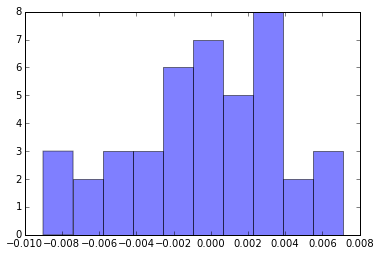

In [21]:
predictionValue = np.zeros(len(custom_label))
prediction_give = np.zeros(len(custom_label))
prediction_gap = np.zeros(len(custom_label))

for i in range(len(custom_label)):

    widthTest = np.delete(width, i)
    eqPonATest = np.delete(eqPonA, i)
    factorTest = np.delete(factor, i)
    
    modelTest = create_model(widthTest, eqPonATest, factorTest)

    predictionValue[i] = modelTest(width[i], eqPonA[i])
    
    prediction_give[i] = fit_give(width[i], eqPonA[i], widthTest, eqPonATest, factorTest, kx=2, ky=ky)
    prediction_gap[i] = angle_gap(width[i], eqPonA[i], widthTest, eqPonATest, 1, 1)
    

predictionDifference = factor - predictionValue

plt.hist(predictionDifference, alpha=0.5)

predictionStd = np.std(predictionDifference, ddof=1) / c4(len(predictionDifference))

print(predictionStd)
print(np.mean(predictionDifference))

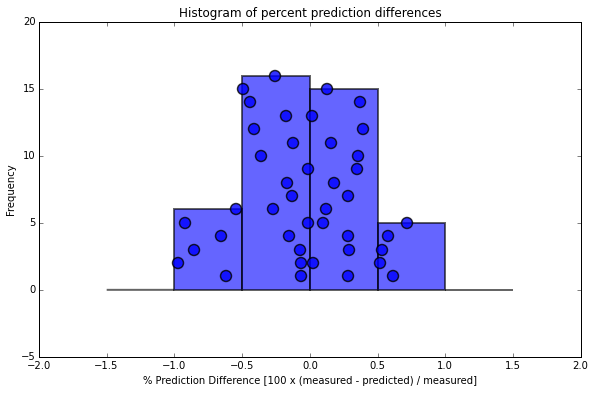

In [22]:
plt.figure(figsize=(6 * 1.618, 6))

percentDifference = 100*(factor - predictionValue) / factor

binStart = -1.5
binEnd = 1.5
binSize = 0.5

bins = np.arange(binStart, binEnd+binSize, binSize)


dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - percentDifference),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):

    binRef = (binNum == i)

    representative_height[binRef] = np.arange(sum(binRef)) + 1


plt.hist(percentDifference,bins, alpha=0.6, lw=2)
plt.scatter(percentDifference, representative_height, zorder=2, s=120, alpha=0.8, lw=1.5)

plt.xlabel(
    '% Prediction Difference '
    '[100 x (measured - predicted) / measured]')
plt.ylabel('Frequency')
plt.title('Histogram of percent prediction differences')

In [23]:
label[np.argsort(np.abs(percentDifference))][::-1]

array(['P3', 'Simon #58 cutout', 'Simon #82 cutout', 'Simon #22 cutout',
       'Simon 3x9cm oval', 'Simon #57 cutout', 'Simon #19 cutout',
       'Simon #32 cutout', 'Simon #6 cutout', 'Simon #83 cutout',
       'Simon 3x6.5cm oval', 'Simon 7cm circle', 'Simon 9cm circle',
       'Simon #14 cutout', 'Simon #109 cutout', 'Simon 4cm circle',
       'Simon #70 cutout', 'P12_1', 'Simon 5cm circle', 'P4',
       'Simon 8cm circle', 'P10', 'Simon #106 cutout', 'Simon #20 cutout',
       'Simon 4x6.5cm oval', 'P40', 'Simon #41 cutout',
       'Simon 5x13cm oval', 'Simon #18 cutout', 'P22', 'Simon 4x10cm oval',
       'P38_1', 'Simon 4x13cm oval', 'Simon #34 cutout',
       'Simon #73 cutout', 'Simon 5x8cm oval', 'Simon 3cm circle',
       'Simon #16 cutout', 'Simon 4x8cm oval', 'Simon #3 cutout',
       'Simon 3x5cm oval', 'Simon #33 cutout'], 
      dtype='<U18')

In [24]:
np.max(np.abs(percentDifference))

0.97058902934567703

In [25]:
from scipy.stats import shapiro, probplot, ttest_1samp

In [26]:
t, ttestProb = ttest_1samp(percentDifference,0)
res_ttest = "%0.4f" %(ttestProb)

if ttestProb < 0.1:
    tSignificance = 'significant'
else:
    tSignificance = 'not significant'

print('t-Test: ' + res_ttest + ' which is ' + tSignificance)

W, shapiroProb = shapiro(percentDifference)
res_norm = "%0.4f" %(shapiroProb)

if shapiroProb < 0.1:
    shSignificance = 'significant'
else:
    shSignificance = 'not significant'

print('Shapiro: ' + res_norm + ' which is ' + shSignificance)



residualStd = np.std(percentDifference,ddof=1) / c4(len(percentDifference))

res_std = "%0.2f" %(residualStd)
print('Standard deviation with bias correction: ' + res_std)

res_mean = "%0.2f" %(np.mean(percentDifference))
print('Mean:' + res_mean)

t-Test: 0.5876 which is not significant
Shapiro: 0.4605 which is not significant
Standard deviation with bias correction: 0.43
Mean:-0.04


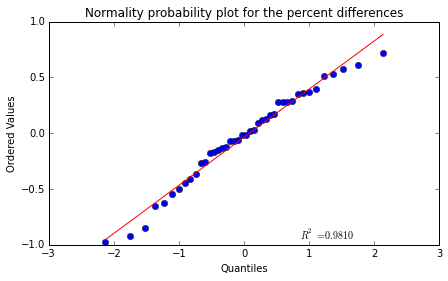

In [27]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(percentDifference, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

0.00382268855492
0.000224663913969


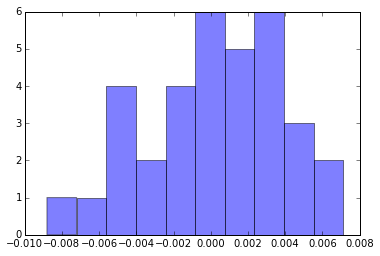

In [28]:
no_extrap = (prediction_give < 0.5) & (prediction_gap < 180)

plt.hist(predictionDifference[no_extrap], alpha=0.5)

predictionStd_no_extrap = np.std(predictionDifference[no_extrap], ddof=1) / c4(len(predictionDifference[no_extrap]))

print(predictionStd_no_extrap)
print(np.mean(predictionDifference[no_extrap]))

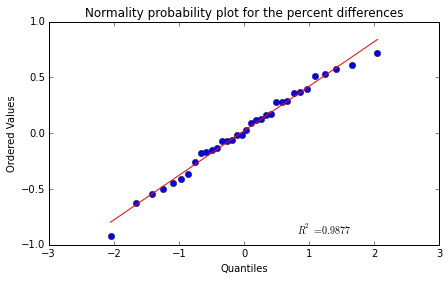

In [29]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(percentDifference[no_extrap], plot=ax);

ax.set_title("Normality probability plot for the percent differences")